In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing as mp
from matplotlib import animation

## Bonus exercise: incorporate objects with insulating material

### Object detector

In [3]:
def object_detector(i, j, num=0, length=0, lower_bound=0, upper_bound=1):
    num = num 
    l = length
    passcheck = 0

    a1 = (1-l)/2
    b1 = (1+l)/2

    a2 = (1-2*l)/3
    a3 = (2-l)/3
    b2 = (1+l)/3
    b3 = (2+2*l)/3

    if num == 1:
        if ((j > a1) and (j < b1)) and ((i > a1) and (i < b1)):
            passcheck = 1

    if num == 2:
        if ((j > a1) and (j < b1)) and \
            (((i > a2) and (i < b2)) or ((i > a3) and (i < b3))):
            passcheck = 1

    if num == 4:
        if (((j > a2) and (j < b2)) or ((j > a3) and (j < b3))) and \
            (((i > a2) and (i < b2)) or ((i > a3) and (i < b3))):
            passcheck = 1
    
    return passcheck


###  Insulating material

In [4]:
'''
The i+1 mesh point that used to calculate the object boundary mesh point (i,j) is the nearest one to the object's next boundary
'''
def SOR_solver_insul_obj(i, j, n_i, c_k, c_k_1, length, delta_x, w=1.8):

    l = length
    a1 = (1-l)/2
    b1 = (1+l)/2

    i_bl = i+1
    i_bu = i-1
    j_bl = j+1
    j_bu = j-1

    a1_x = a1/delta_x
    b1_x = b1/delta_x

    if j > a1_x and j < b1_x:
        if i < a1_x and i > a1_x-1:
            i_bl = int(np.floor(b1_x))+1
        elif i > b1_x and i < b1_x+1:
            i_bu = int(np.floor(a1_x))

    if i > a1_x and i < b1_x:
        if j < a1_x and j > a1_x-1:
            j_bl = int(np.floor(b1_x))+1
        elif j > b1_x and j < b1_x+1:
            j_bu = int(np.floor(a1_x))
    
    # boundary conditions
    if i == 0:
        c_new = w/4 * (c_k[i+1, j] + c_k_1[-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
    elif i == n_i-1:
        c_new = w/4 * (c_k[0, j] + c_k_1[i-1, j] + c_k[i, j+1] + c_k_1[i, j-1]) + (1-w) * c_k[i, j]
        
    else:
        c_new = w/4 * (c_k[i_bl, j] + c_k_1[i_bu, j] + c_k[i, j_bl] + c_k_1[i, j_bu]) + (1-w) * c_k[i, j]

    return c_new

In [5]:
def implement_sor_insul(max_ite=5000, w=1.8, e=1e-5, N=50, num=0, length=0):
    ##########################################################
    # Initialize valuse
    max_ite = max_ite
    e = e
    delta_x = 1 / N
    # check the number of sinks
    num = num
    if num == 3 or num > 4:
        print('num can only take value 1, 2 or 4!')
        return None
    ###########################################################
    l = length

    # Create tracker matrix
    c_store_s = np.zeros((max_ite+1, N, N))
    c_store_s[:, :, -1].fill(1)

    # Store the convergence measure delta
    delta_s = np.zeros(max_ite+1)

    # create matrix to store function value at the previous step
    c_keep_s = np.zeros((N, N))
    c_keep_s[:, -1].fill(1)

    # Create matrix to store function value at the current step
    c_s = np.zeros((N, N))
    c_s[:, -1].fill(1)
    ##################################################################################
    # apply the sor method (pity that I don't know how to enable parellel computing :( )
    
  
    for k in range(max_ite):
        for j in range(N-2):
            j += 1
            for i in range(N):
                ####################################################################          
                # Check if the point (i,j) lies within the sink!
                passcheck = object_detector(i=i*delta_x, j=j*delta_x, num=num, length=length)
                if passcheck == 0:
                    c_s[i, j] = SOR_solver_insul_obj(i, j, n_i=N, c_k=c_keep_s, c_k_1=c_s, w=w, length=l, delta_x=delta_x)
                else:
                    c_s[i, j] = 0
                ####################################################################
    
        # Update the tracker
        c_store_s[k+1, :, :] = c_s
        
        # apply the threshold
        diff_s = c_s - c_keep_s
        delta_s[k] = abs(max(diff_s.max(), diff_s.min(), key=abs))

        if delta_s[k] < e:
            break

        # update the store matrix
        c_keep_s = np.copy(c_s)
    #####################################################################################

    return c_store_s, delta_s, k


In [28]:
c_store_s_s, delta_s_s, k_s = implement_sor_insul(num=1, length=0.5)
print(k_s)

382


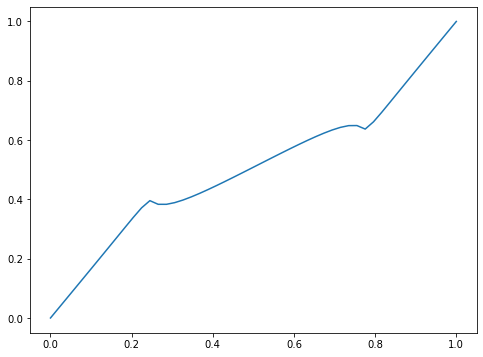

In [44]:
y_plot = np.linspace(0, 1, 50)
plt.plot(y_plot, c_store_s_s[383, 38, :], label='ite=converge')
plt.show()

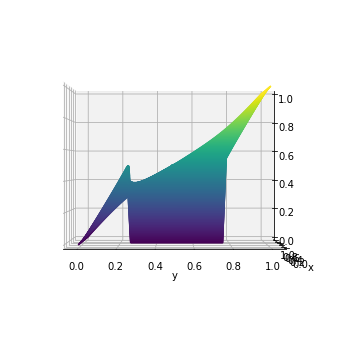

In [32]:
axt = plt.axes(projection='3d')

plt.rcParams['figure.figsize'] = (8, 6)

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)

axt.contour3D(X, Y, c_store_s_s[383, :, :], 500)

axt.set_xlabel('y')
axt.set_ylabel('x')

axt.view_init(0, -90)

### Define optimizor

In [8]:
def optimize_sor_insul(lower_bound=1.7, upper_bound=2, N=50, max_ite=5000, e=1e-5, num=0, length=0):
    a = lower_bound
    b = upper_bound
    check = 0
    
    for k in range(max_ite):

        # Calculate the midpoint
        c = (a + b) / 2

        convergency_l = implement_sor_insul(max_ite=max_ite, w=a, e=e, N=N, num=num, length=length)

        # We dont really need the upper bound function value
        # Since we have prior knowledge of the interval we are studying

        # convergency_u = implement_sor(max_ite=max_ite, w=b, e=e, N=N)
        convergency_m = implement_sor_insul(max_ite=max_ite, w=c, e=e, N=N, num=num, length=length)

        k_l = convergency_l[2]
        # k_u = convergency_u[2]
        k_m = convergency_m[2]

        # Apply the secant method
        if k_m < k_l:
            a = c
        if k_m > k_l:
            b = c

        # Check if midpoint and lower bound by chance lie symmetriclly
        if k_m == k_l:
            check += 1
        if check == 2:
            print(convergency_m[2], end=',')
            break

        if k == max_ite-1:
            print('Failed to find the optimal solution in the max iteration steps!')
    
    return convergency_m[2], c

In [9]:
def optimize_experiment_insul(lower_bound=10, upper_bound=100, n_interval=10, num=0, length=0):
    N_value = np.linspace(lower_bound, upper_bound, n_interval)
    optimal_step = np.zeros(len(N_value))
    optimal_w = np.zeros(len(N_value))

    for i, n in enumerate(N_value):
        optimal = optimize_sor_insul(N=int(n), num=num, length=length)
        optimal_w[i] = optimal[1]
        optimal_step[i] = optimal[0]
    
    return N_value, optimal_w, optimal_step

In [30]:
l = 0.25
if __name__ == '__main__':
    N_o, opt_w_o, opt_step_o = optimize_experiment_insul(lower_bound=1, upper_bound=100, n_interval=10, num=1, length=l)

0,64,115,175,248,190,472,412,465,519,